## Creating Lo-Fi data for small/large amplitude oscillatory shear (S/LAOS) rheometry
In this notebook, the synthetic generation of Lo-Fi data is introduced based on the given Hi-Fi data. This is a more intricate one as we need to introduce some form of physics to generate the Lo-Fi data.

<img src="../LoFi_LAOS.jpg" alt="MFNN architecture" width="600"/>

First of all, we need to extract the time shift for each S/LAOS test. Note that the given data is in sheets. For each sheet in `Data_HF_SAOS_raw.xlsx`, we need to extract the shifted time, maxietam strain, angular frequency, stress, strain, and strain rate, respectively, by calling the `extractor()` function.


### Importing dependencies

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor  # Import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
np.set_printoptions(suppress=True)
path = os.getcwd()
files = os.listdir(path)
df = {}
url = 'https://github.com/procf/RhINNs/raw/main/MFNN/SAOS/Data_HF_SAOS_raw.xlsx'
#Uncomment the below line to run locally
# url = pd.ExcelFile('Data_HF_SAOS_raw.xlsx')

df = pd.read_excel(url, sheet_name=None)
data = [[k,v] for k,v in df.items()]
t_train, g_train, w_train = np.array([]), np.array([]), np.array([])
s_train = np.array([])

def pos_finder(vector):
    vector = np.array(vector)
    for i in range(len(vector) - 1):
        if vector[i] < 0 and vector[i + 1] >= 0:
            return i + 1
    return -1
    
def extractor(i):
    data[i][1] = data[i][1].dropna()
    print(data[i][0])
    
    #handling the time shift
    ind = pos_finder(data[i][1]['Strain'])
    t0 = data[i][1]['Step time'].iloc[ind]
    ymax = data[i][1]['Stress'].iloc[ind]
    
    #column extraction 
    St = data[i][1]['Strain']
    SR = data[i][1]['Shear rate']
    Time = data[i][1]['Step time']
    w = data[i][1]['Frequency']
    G0 = data[i][1]['G0']
    Stress = data[i][1]['Stress']
    Time_adj = Time - t0# + 1.*np.pi/w
    Time_adj = Time_adj
    return Time_adj, G0, w, Stress, St, SR


### Extracting $\tau$ and $\eta$
Then, you need to run the following cell for all sheets in `Data_HF_SAOS_raw.xlsx`. For each sheet, we fit a single-mode Maxwell VE model and extract $\tau$ and $\eta$ as a function of $\gamma_0$, $\omega$, and $t$. Note that we are using the `odeint` package, which is an ODE solver. Similar to other ODE solvers, we need initial condition (`y0`), `initial_guess`, and `bounds`. For each sheet, an appropriate `y0` is needed. For this particular sheet, `y0` is 90 Pa.

10rads - 100%
Fitted eta: 0.1618354402565727
Fitted tau: 0.14525531285863694
y0=90


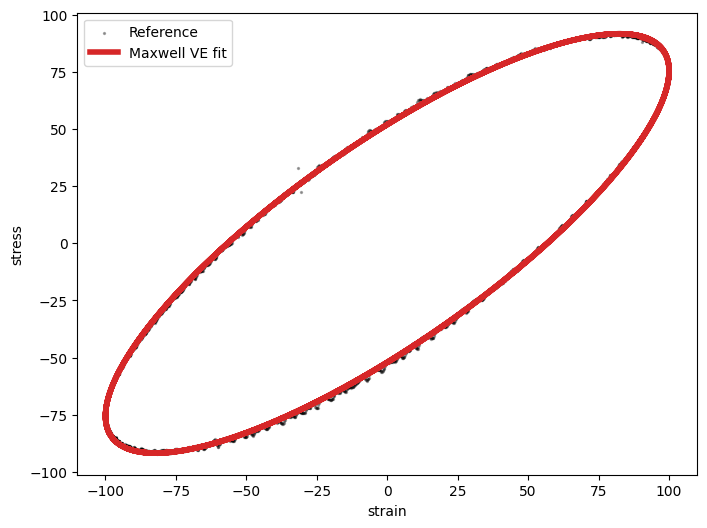

In [3]:
t_train, g_train, w_train, s_train, st_train, sr_train = extractor(i=4)
Norm = False
if Norm:
    tmax = 5.7835
    gmax = 1000.
    wmax = 10.
    smax = 216.73
    t_train, g_train, w_train, s_train = t_train/tmax, g_train/gmax, w_train/wmax, s_train/smax
else:
    tmax = 1.
    gmax = 1.
    wmax = 1.
    smax = 1.
def maxwell_ve(y, t, eta, tau):
    gdot = g0 * omega * np.cos(omega * t*tmax*wmax)
    dydt = (1.0 / tau) * (eta * gdot - y)
    return dydt
def fit_function(t, eta, tau):
    y_pred = odeint(maxwell_ve, y0, t, args=(eta, tau))
    return y_pred[:, 0]

g0 = np.unique(g_train)
omega = np.unique(w_train)
t = t_train
y = s_train
g = g0 * np.sin(omega * t_train*tmax*wmax)
gd = g0 *omega* np.cos(omega * t_train*tmax*wmax)

y0 = 90

initial_guess = [0.1, 0.5]  # Initial guess for eta and tau
bounds = ([0.0, 0.0], [np.inf, np.inf])  # Example bounds: eta in [0, 1], tau > 0
fit_params, covariance = curve_fit(fit_function, t, y,
                                   p0=initial_guess,
                                   bounds=bounds,
                                  method='trf')

# Extract the fitted parameters
eta_fit, tau_fit = fit_params

# Print the results
print("Fitted eta:", eta_fit)
print("Fitted tau:", tau_fit)
print(f'y0={y0}')

y_predicted = fit_function(t, eta_fit, tau_fit)

plt.figure(figsize=(8, 6))
plt.scatter(g, y, label='Reference', s=2, color='k', alpha=0.3)
plt.plot(g, y_predicted, '-', label='Maxwell VE fit', linewidth=4, color='tab:red')
plt.xlabel('strain')
plt.ylabel('stress')
plt.legend()
plt.show()

For this sheet, $\tau$ and $\eta$ are 0.16183 and0.14525, respectively. We do the same thing for all stress curves to obtain the following table:

In [4]:
#The entire fitting parameters
y_fit = np.array([
    [0.24902885728714302, 0.20231387763810893],
    [0.24677501931217188, 0.19541009153878053],
    [0.10792513590215644, 0.08608351084804909],
    [0.21422001411545832, 0.1669592784257872],
    [0.1618354402565727, 0.14525531285863694],
    [0.022619193227381137, 0.055887379725958725],
    [0.2157641543539199, 0.1804046120793453],
    [0.06277783265770162, 0.062331921507078655]  
])

x_fit = np.array([
[1., 10.],
[1., 100.],
[1., 1000.],
[10., 10.],
[10., 100.],
[10., 1000.],
[5., 50.],
[5., 500.]])
y0_fit = np.array([1.79003, 18., 90., 8.81856, 90., 40., 39., 90.])

### Masking Hi-Fi data
Here, and depending on which stress loop we wish to omit from MFNN training, we select from `hf_set`.

In [5]:
hf_set = [0, 1, 2, 3, 4, 5, 6]
y_max = y_fit[hf_set]
x_max = x_fit[hf_set]
y_00 = y0_fit[hf_set]
set1 = {tuple(row) for row in x_fit}
set2 = {tuple(row) for row in x_max}
diff = np.array([list(row) for row in (set1 - set2)])
print('The masked set(s) are:\n', diff)

The masked set(s) are:
 [[  5. 500.]]
Stored 'diff' (ndarray)


### Regression of $\tau$ and $\eta$ on $\gamma_0$ and $\omega$

Here, we have several options to select the regression kernel. The output of this cell is the regressed $\tau$ and $\eta$ values for each kernel.

In [9]:
poly_regressor = make_pipeline(PolynomialFeatures(degree=2), MultiOutputRegressor(LinearRegression()))
poly_regressor.fit(x_max, y_max)
poly_predictions = poly_regressor.predict(x_max)
rf_regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_regressor.fit(x_max, y_max)
rf_predictions = rf_regressor.predict(x_max)
mlp_regressor = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(20, 20, 20, 20),
                                                  max_iter=10000,
                                                  random_state=4,
                                                  solver='lbfgs',
                                                 activation='tanh',
                                                 alpha=1e-3))
mlp_regressor.fit(x_max, y_max)
mlp_predictions = mlp_regressor.predict(x_max)

print("Second-Order Polynomial Regression Predictions:")
print(poly_predictions)

print("\nRandom Forest Regression Predictions:")
print(rf_predictions)

print("\nMLP Regression Predictions:")
print(mlp_predictions)

Second-Order Polynomial Regression Predictions:
[[0.26031131 0.20609677]
 [0.23436432 0.19124891]
 [0.10905338 0.0864618 ]
 [0.20293756 0.16317639]
 [0.17424614 0.14941649]
 [0.02149095 0.05550909]
 [0.21576415 0.18040461]]

Random Forest Regression Predictions:
[[0.24314316 0.19546948]
 [0.22335812 0.19073349]
 [0.09429807 0.08587317]
 [0.20210047 0.1636716 ]
 [0.17954671 0.15515398]
 [0.05908203 0.0712271 ]
 [0.22715763 0.18647914]]

MLP Regression Predictions:
[[0.24902771 0.2045863 ]
 [0.24589643 0.19141418]
 [0.10766866 0.08579709]
 [0.21426079 0.16265187]
 [0.15935612 0.14870311]
 [0.0240165  0.05817701]
 [0.21752091 0.18104101]]


### Hi-Fi data extraction and sampling
Since we used the raw Hi-Fi data, we need to extract those shifted Hi-Fi data and use them for MFNN training. Also, the given Hi-Fi data was too dense, and we sample every 40 of them.

In [10]:
g0_hf, t_hf, w_hf = np.array([]), np.array([]), np.array([])
g_hf, gdot_hf, s_hf = np.array([]), np.array([]), np.array([])

for i in hf_set:

    t_test, g0_test, w_test, s_test, st_test, sr_test = extractor(i)
    
    g0_hf = np.append(g0_hf, g0_test)
    t_hf = np.append(t_hf, t_test)
    w_hf = np.append(w_hf, w_test)
    
    g_hf = np.append(g_hf, st_test)
    gdot_hf = np.append(gdot_hf, sr_test)
    s_hf = np.append(s_hf, s_test)

    
    
sampled_indices = np.arange(0, len(t_hf), 40)
t_hf_sampled = t_hf[sampled_indices]
g0_hf_sampled = g0_hf[sampled_indices]
w_hf_sampled = w_hf[sampled_indices]
g_hf_sampled = g_hf[sampled_indices]
gdot_hf_sampled = gdot_hf[sampled_indices]
s_hf_sampled = s_hf[sampled_indices]

1rads - 10%
1rads - 100%
1rads - 1000%
10rads - 10%
10rads - 100%
10rads - 1000%
5rads - 50%


Almost there. Now, for each set in `lf_set`, which is essentially all the loops, we call the `fit_function()` function, which predicts the linear VE stress response as a function of `t_pred`, `eta_pred`, and `tau_pred`. We then append every variable to an empty vector, and call that our Lo-Fi data. Keeping an eye on the top image as reference can also help. :)

1rads - 10%


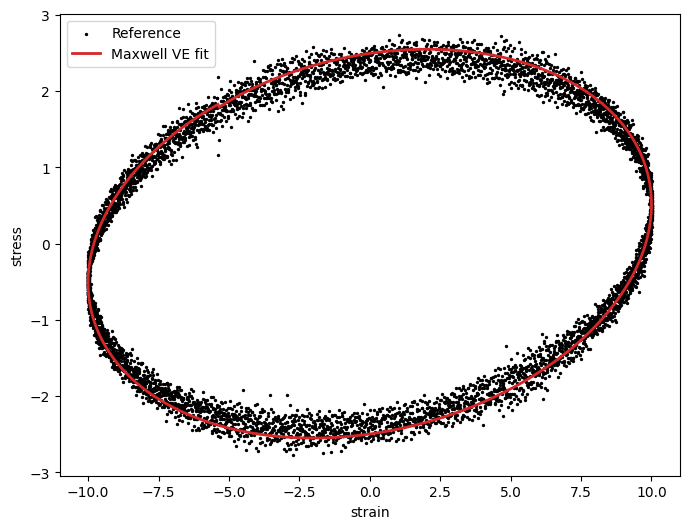

1rads - 100%


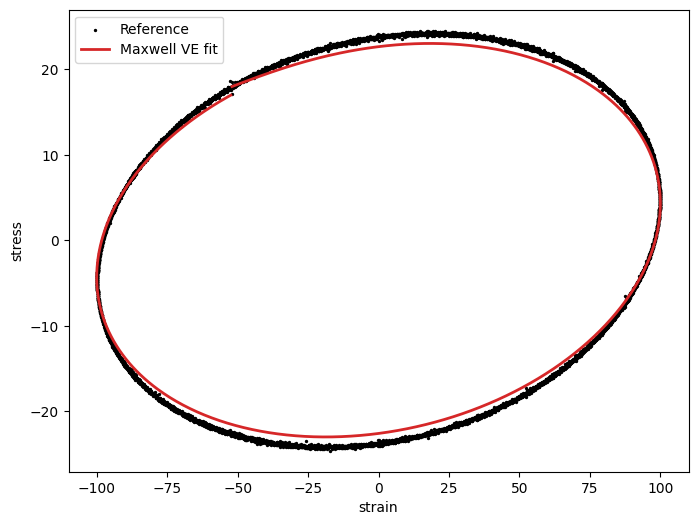

1rads - 1000%


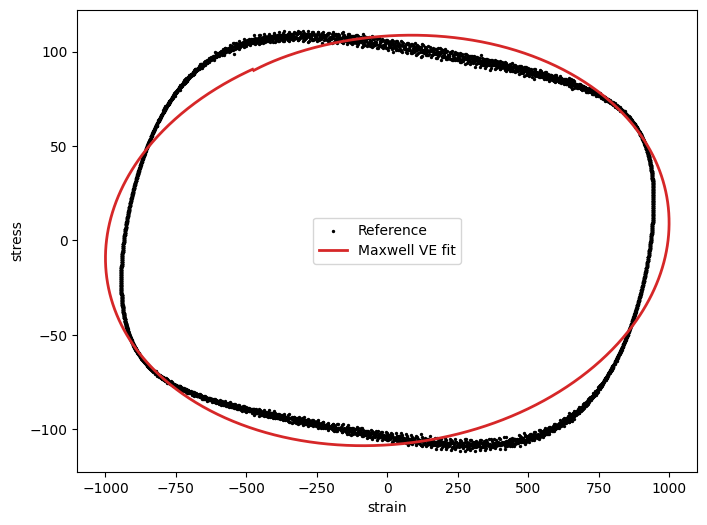

10rads - 10%


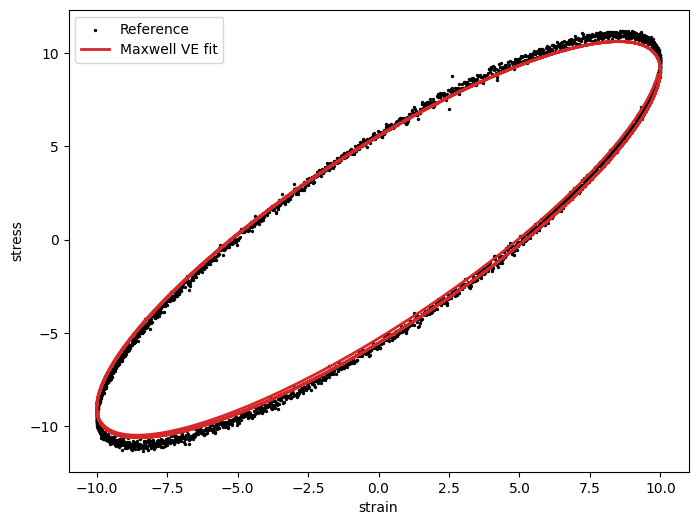

10rads - 100%


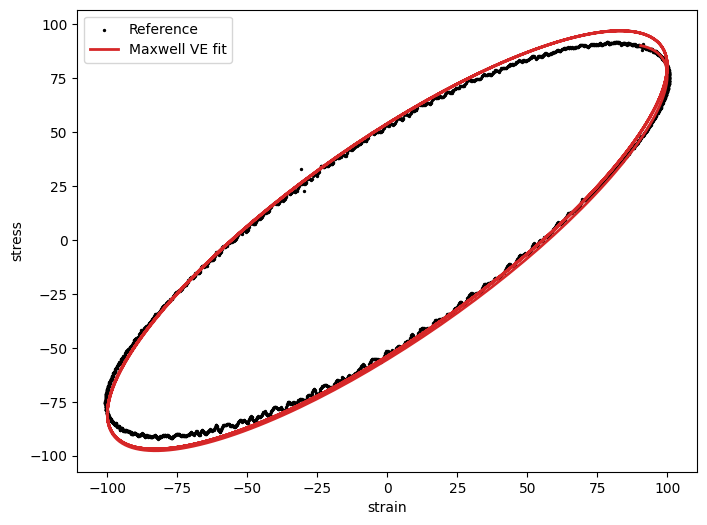

10rads - 1000%


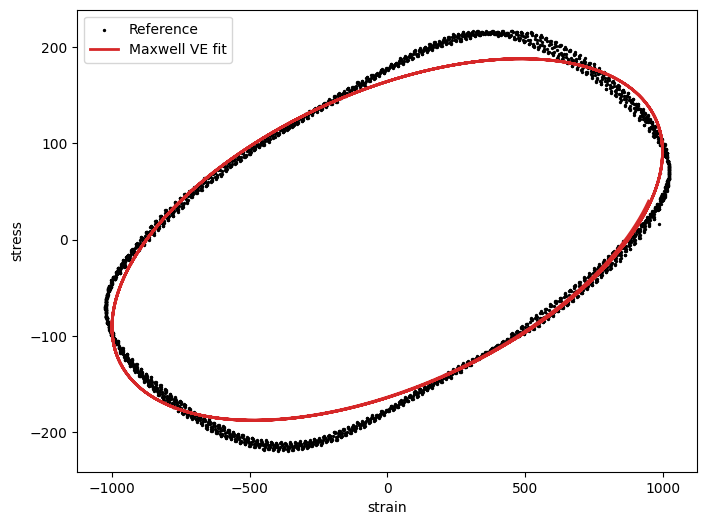

5rads - 50%


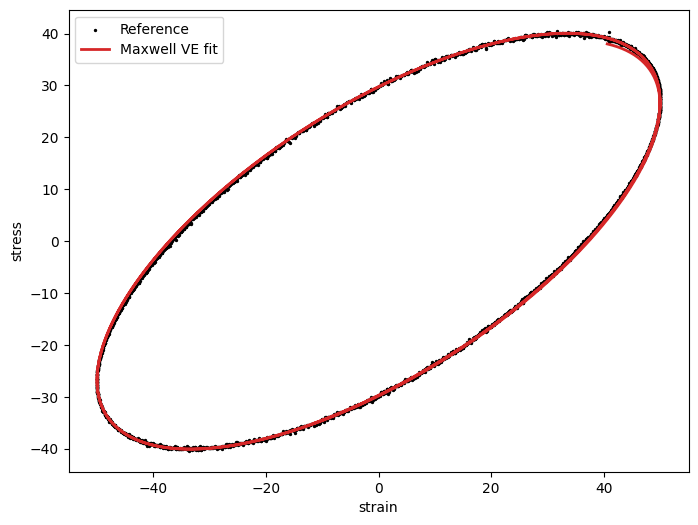

5rads - 500%


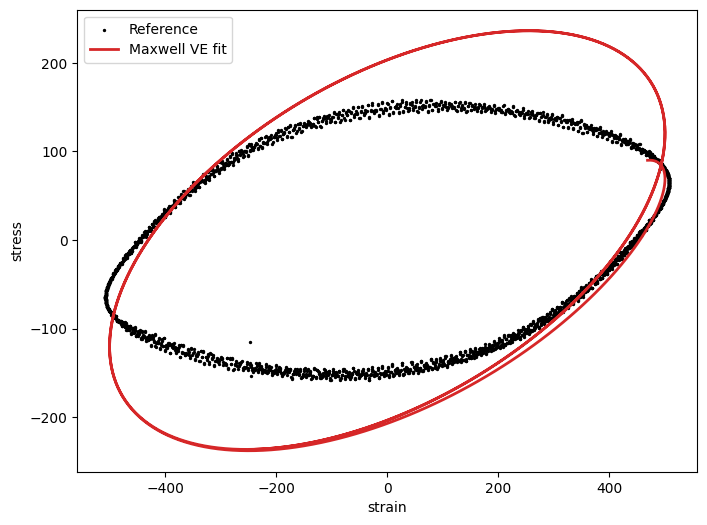

In [11]:
y000 = [1.79003, 18., 90., 8.81856, 90., 40., 38., 90.]
g00 = x_fit[:,1]
omega0 = x_fit[:,0]
lf_set = [0, 1, 2, 3, 4, 5, 6, 7]
N_exp = int(10.*len(s_hf_sampled)/len(lf_set))

g0_exp, t_exp, w_exp = np.array([]), np.array([]), np.array([])
g_exp, gdot_exp, s_exp = np.array([]), np.array([]), np.array([])

for i in lf_set:

    t_test, g0_test, w_test, s_test, st_test, sr_test = extractor(i)

    omega = omega0[i]
    g0 = g00[i]
    y0 = y000[i]
    
    x_pred = np.reshape([omega, g0], (1,-1))
    eta_pred, tau_pred = poly_regressor.predict(x_pred)[0]

    t_pred = np.linspace(min(t_test), max(t_test), N_exp)
    y_pred = fit_function(t_pred, eta_pred, tau_pred)
    
    g_pred = g0 * np.sin(omega * t_pred)
    gdot_pred = g0*omega*np.cos(omega * t_pred)/100.
    
    #LF generation
    g0_exp = np.append(g0_exp, g0*np.ones(N_exp))
    t_exp = np.append(t_exp, t_pred)
    w_exp = np.append(w_exp, omega*np.ones(N_exp))
    
    g_exp = np.append(g_exp, g_pred)
    gdot_exp = np.append(gdot_exp, gdot_pred)
    s_exp = np.append(s_exp, y_pred)

    plt.figure(figsize=(8, 6))
    plt.scatter(st_test, s_test, label='Reference', s=2, color='k')
    plt.plot(g_pred, y_pred, label='Maxwell VE fit', color='tab:red', lw=2)
    plt.xlabel('strain')
    plt.ylabel('stress')
    plt.legend()
    plt.show()

### Exporting the Lo-Fi and Hi-Fi SAOS data
As mentioned above, and due to the time shift, the Hi-Fi data is also generated here based on the raw Hi-Fi data.

In [12]:
df_LF_raw = np.column_stack([g0_exp, t_exp, w_exp, g_exp, gdot_exp, s_exp])
df_LF = pd.DataFrame(df_LF_raw, columns = ['G0','Time', 'AngFreq', 'Strain', 'StrainRate', 'Stress'])
df_LF.to_excel("Data_LF_SAOS.xlsx", index=False)

In [13]:
df_HF_raw = np.column_stack([g0_hf_sampled, t_hf_sampled,
                             w_hf_sampled, g_hf_sampled,
                             gdot_hf_sampled, s_hf_sampled])
df_HF = pd.DataFrame(df_HF_raw, columns = ['G0','Time', 'AngFreq', 'Strain', 'StrainRate', 'Stress'])
df_HF.to_excel("Data_HF_SAOS.xlsx", index=False)